In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import trainer
from trainer import device

In [4]:
import re

In [5]:
# load dictionary (100k words) from /usr/share/dict/words
with open('/usr/share/dict/words', 'r') as f:
    vocab = {}
    for line in f:
        word = line.strip().replace("'","").lower()
        if not word in vocab:
            vocab[word] = len(vocab)

words = sorted(vocab.keys(), key=lambda w: vocab[w])

assert(len(words) == len(vocab))
assert(vocab[words[42]] == 42)

In [6]:
# given a sentence, generate skip-gram pairs of words as indices
phrase_re = re.compile(r'[!.;()"\']+')
word_re = re.compile(r'[,\s-]+')

def sentences(str):
    return [[w.lower() for w in word_re.split(p) if len(w) > 0] for p in phrase_re.split(str.lower())]

def skipgrams(str, n=2):
    r = []
    for p in sentences(str):
        ws = [vocab[w] for w in p if w in vocab]
        for i, w in enumerate(ws):
            for j in range(i-n, i+n+1):
                if j >= 0 and j < len(ws) and j != i:
                    r.append((ws[i], ws[j]))
    return r

In [7]:
# given a file, iterate over skipgrams in batches of a given size
# batch is represented as a one-hot vector for now
def skipgram_iter(path, batch_size):
    batch = []
    with open(path, 'r', errors='ignore') as f:
        for line in f:
            batch += skipgrams(line)
            while len(batch) >= batch_size:
                xb = torch.tensor([torch.tensor(x, dtype=torch.long) for x,y in batch[:batch_size]])
                yb = torch.tensor([torch.tensor(y, dtype=torch.long) for x,y in batch[:batch_size]])
                yield F.one_hot(xb, len(vocab)).float(), yb
                batch = batch[batch_size:]

In [8]:
# word2vec network
class Word2Vec(nn.Module):
    def __init__(self, n_hidden):
        super().__init__()
        self.u = nn.Linear(len(vocab), n_hidden, bias=False)
        self.v = nn.Linear(n_hidden, len(vocab), bias=False)
        
    def forward(self, x):
        return self.v(self.u(x))
    
    def loss(self, p, y):
        return F.cross_entropy(p, y)

Train [90.477M params]: 20 epochs took 474.45 sec, train loss 7.901654, val loss 7.901654


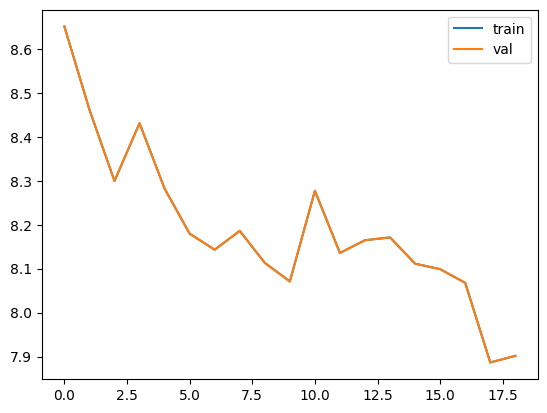

In [9]:
# datasetSentences.txt has ~20K 32-pair batches
net = Word2Vec(512).to(device)
trainer.train(net, train_data=skipgram_iter("datasetSentences.txt", batch_size=32), val_data=None, batch_limit=1000, epochs=20)

In [22]:
netw = (torch.transpose(net.u.weight.data, 0, 1) + net.v.weight.data).detach().cpu()

In [67]:
def encode(w):
    return netw[vocab[w]]

def dist(w1, w2):
    v1 = encode(w1)
    v2 = encode(w2)
    return torch.sqrt(((v1 - v2)**2).sum()).item()

def decode(v, k=3):
    d = netw - torch.unsqueeze(v, 0)
    l2 = (d * d).sum(1)
    tk = torch.topk(l2, k, largest=False).indices
    return [(words[i], l2[i].item()) for i in tk]

In [92]:
decode(encode("man") - encode("woman") + encode("her"))

[('his', 26.837474822998047),
 ('their', 28.420135498046875),
 ('her', 30.70106315612793)]